# Prerequisites

To run this notebook, `tensorflow` and `microfaune` need to be installed.

To train or check prediction results, the datasets *freefield* and *warblr* must be unzipped in a folder (its path is specified in the next cell).
The folder tree should look like this:
* [data_dir_path]/
  * ff1010bird_wav/
    * labels.csv
    * wav/
  * warblrb10k_public_wav/
    * labels.csv
    * wav/


In [1]:
train = True

# imports and function definitions

In [38]:
%matplotlib notebook
from collections import Counter
import csv
from datetime import datetime
from glob import glob
import pickle
import h5py
import os

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

from skimage import util
from scipy import fftpack
from scipy import signal
import librosa
from microfaune import audio

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.contrib.layers import group_norm
from tensorflow.math import reduce_max

In [3]:
data_dir_by_user = {
    "florent": "/home/florent/personnel/data/"
}

data_dir = data_dir_by_user[os.getenv("USER")]

In [4]:
def create_model(input_shape=[None, None, 1], n_convfilter=64, n_convfilter_growth=1, n_recfilter=64, n_densefilter=64,
                 conv_l2reg=1e-3, dense_l2reg=1e-2):

    conv_reg = keras.regularizers.l2(conv_l2reg)
    dense_reg = keras.regularizers.l2(dense_l2reg)
    spec = layers.Input(shape=input_shape, dtype=np.float32)
    
    batchnorm_momemtum = 0.98
    batchnorm_layer = lambda: layers.BatchNormalization(momentum=batchnorm_momemtum)
    
    n_filter = n_convfilter
    x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(spec)
    x = layers.BatchNormalization(momentum=batchnorm_momemtum)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
    x = layers.BatchNormalization(momentum=batchnorm_momemtum)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D((1, 2))(x)

    n_filter= int(n_filter * n_convfilter_growth)
    x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
    x = layers.BatchNormalization(momentum=batchnorm_momemtum)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
    x = layers.BatchNormalization(momentum=batchnorm_momemtum)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D((1, 2))(x)

    n_filter= int(n_filter * n_convfilter_growth)
    x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
    x = layers.BatchNormalization(momentum=batchnorm_momemtum)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
    x = layers.BatchNormalization(momentum=batchnorm_momemtum)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D((1, 2))(x)

    x = reduce_max(x, axis=-2)

#     x = layers.GRU(n_recfilter, return_sequences=True)(x)
#     x = layers.GRU(n_recfilter, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(n_densefilter, activation="relu", kernel_regularizer=dense_reg))(x)
    local_pred = layers.TimeDistributed(layers.Dense(1, activation="sigmoid", kernel_regularizer=dense_reg),
                                        name="local")(x)
    pred = reduce_max(local_pred, name="global", axis=-2)

    model = keras.Model(inputs=spec, outputs=pred)
    return model

In [176]:
def sliding_window(a, width=2048, overlap=1024):
    return util.view_as_windows(a, window_shape=(width, ), step=overlap)

def wav2fft(wav_file, sr=44100, width=2048, overlap=1024):
    fs, data = audio.load_wav(wav_file)
    if sr != fs:
        data = librosa.core.resample(data, fs ,sr)
    F = []
    for w in sliding_window(data/data.max(), width, overlap):
        F.append(fftpack.rfft(w))
    return np.array(F)

def fft2mel(F, sr=44100, n_mels=40):
    mel = librosa.filters.mel(sr=sr, n_fft=2*F.shape[1]-1, n_mels=n_mels)
    X = np.abs(F.T)**2
    X_log = 10 * np.log10(X+1e-6)
    return (mel.dot(X_log)).T

In [62]:
def dump_fft_datasets(data_dir, sr=44100, window_length=2048, overlap=1024, duration=10, overwrite=False):
    dump_file = os.path.join(data_dir,
                             f"dataset_fft-win_{window_length}"
                             f"-ove_{overlap}-dur_{duration}.hdf5")
    if os.path.exists(dump_file) and not overwrite:
        return dump_file
    else:
        with h5py.File(dump_file, "w") as f:
            f.create_group("X")
            f.create_group("Y")
            f.create_group("uids")

    potential_datasets = ["ff1010bird_wav", "warblrb10k_public_wav", "BirdVox-DCASE-20k"]
    tmp_dirs = [os.path.join(data_dir, d) for d in potential_datasets]
    datasets_dirs = [d for d in tmp_dirs if os.path.exists(d)]
    X = []
    Y = []
    uids = []
    for dataset_dir in datasets_dirs:
        dump_fft(dataset_dir, dump_file, sr, window_length, overlap, duration)
    
    return dump_file


def dump_fft(dataset_dir, dump_file, sr=44100, window_length=2048, overlap=1024, duration=10):
    print(dataset_dir)
    labels_file = os.path.join(dataset_dir, "labels.csv")
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, y in reader:
                labels[name] = y
    else:
        raise FileNotFoundError(f"Labels file not found in {dataset_dir}.")
           
    audio_files = glob(os.path.join(dataset_dir, "*/*.wav"))
    h5_file = h5py.File(dump_file, "a")
    count = 0
    rej = 0
    min_length = np.floor(duration*sr/overlap)-1
    for i, audio_file in enumerate(audio_files):
        file_id = os.path.basename(audio_file)[:-4]
        print(f"{i+1:04d}/{len(audio_files)}: {file_id:20s}", end="\r")

        if file_id not in labels:
            continue
        x = wav2fft(audio_file, sr, window_length, overlap)
        if x.shape[0] < min_length:
#             print(f"File {file_id} too short: {x.shape[0]} < {min_length}")
            rej += 1
            continue
        count += 1
        h5_file["X"].create_dataset(file_id, data=x.astype(np.float16))
        h5_file["Y"].create_dataset(file_id, data=labels[file_id])
    print(f"{count} audio files successfully processed. ({rej} too shorts)")
    h5_file.close()
    return 0

In [136]:
def dump_noise_dataset(data_dir, sr=44100, window_length=2048, overlap=1024, duration=10, overwrite=False):
    dump_file = os.path.join(data_dir,
                             f"citeU_noise_fft-win_{window_length}"
                             f"-ove_{overlap}-dur_{duration}.hdf5")
    if os.path.exists(dump_file) and not overwrite:
        return dump_file
    
    noise_files = glob(os.path.join(data_dir, "citeU", "*_05*.wav"))
    with h5py.File(dump_file, "w") as f:
        for i, noise_file in enumerate(noise_files):
            noise_uid = os.path.basename(noise_file)[:-4]
            print(f"{i+1:04d}/{len(noise_files)}: {noise_uid:20s}", end="\r")
            
            F = wav2fft(noise_file, sr, window_length, overlap)
            if np.any(np.isnan(F)):
                print("inf values")
                return 
            l = int(duration*sr/overlap+1)
            ind = 0
            while ind+l < F.shape[0]:
                f.create_dataset(f"{noise_uid}_{ind}", data=F[ind:ind+l, :].astype(np.float16))
                ind += l
            
    return dump_file

In [137]:
noise_dump_file = dump_noise_dataset(data_dir, 44100, 2048, 1024, 10, overwrite=True)

In [ ]:
with h5py.File(dump_file, "r") as f:
    for uid in f["X"]:
        if np.count_nonzero(np.isinf(f["X"][uid][()])):
            print(uid)

In [64]:
dump_file = dump_fft_datasets(data_dir, 44100, 2048, 1024, 10, overwrite=True)

/home/florent/personnel/data/ff1010bird_wav
7690 audio files successfully processed. (0 too shorts)
/home/florent/personnel/data/warblrb10k_public_wav
7883 audio files successfully processed. (117 too shorts)
/home/florent/personnel/data/BirdVox-DCASE-20k
20000 audio files successfully processed. (0 too shorts)


# Create model 

In [177]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, type_, dump_file, noise_file, batch_size=32, alpha=0.5):
        self.f = h5py.File(dump_file, "r")
        self.noise_f = h5py.File(noise_file, "r")
        self.noise_uids = [uid for uid in self.noise_f]
        uids = [uid for uid in self.f["X"]]
        np.random.seed(0)
        p = np.random.permutation(len(uids))
        self.type = type_
        if type_ == "train":
            self.uids = [uids[i] for i in p[:int(len(p)*0.85)]]
        elif type_ == "val":
            self.uids = [uids[i] for i in p[int(len(p)*0.85):]]
                
        self.n = len(self.uids)
        self.batch_size = batch_size
        
        self.alpha = alpha
        self.shuffle()
        
    def __len__(self):
        return int(np.floor(self.n)/self.batch_size)
    
    def __getitem__(self, index):
        batch_inds = self.inds[self.batch_size*index:self.batch_size*(index+1)]
        self.counter += self.batch_size
        if self.counter >= self.n:
            self.shuffle()
        min_l = np.min([self.f["X"][self.uids[i]].shape[0] for i in batch_inds])
        F = np.array([self.f["X"][self.uids[i]][:min_l, :] for i in batch_inds])
        
        if self.type == "train":
            uids = np.random.choice(self.noise_uids, self.batch_size)
            for i, uid in enumerate(uids):
                F[i, ...] = self.alpha*F[i, ...] + (1-self.alpha)*self.noise_f[uid][:min_l, :]
        X = (np.array([fft2mel(f.astype(np.float32)) for f in F])[..., np.newaxis])
        
        Y = np.array([self.f["Y"][self.uids[i]][()] for i in batch_inds], dtype=int)
        return X, Y
    
    def shuffle(self):
        self.inds = np.random.permutation(self.n)
        self.counter = 0

In [178]:
train_data_generator = DataGenerator("train", dump_file, noise_dump_file, 16, alpha=0.7)
X, Y = train_data_generator[0]

In [179]:
model = create_model(n_convfilter=32, n_convfilter_growth=1.5, n_recfilter=64, n_densefilter=64)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 32)    320       
_________________________________________________________________
batch_normalization_18 (Batc (None, None, None, 32)    128       
_________________________________________________________________
re_lu_18 (ReLU)              (None, None, None, 32)    0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, None, None, 32)    128       
_________________________________________________________________
re_lu_19 (ReLU)              (None, None, None, 32)    0   

In [ ]:
if train:
    batch_size = 32
    train_data_generator = DataGenerator("train", dump_file, noise_dump_file, batch_size, alpha=0.7)
    val_data_generator = DataGenerator("val", dump_file, noise_dump_file, batch_size, alpha=0.7)
    model = create_model(n_convfilter=32)
    
    optimizer = keras.optimizers.Adam(lr=0.001)
    metrics = ['accuracy']  # , keras.metrics.FalseNegatives()]
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=metrics)

    alpha = 0.5  
#     reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                                   patience=5, min_lr=1e-5)

    history = model.fit_generator(train_data_generator, steps_per_epoch=400, epochs=20,
                                  validation_data=val_data_generator,
                                  class_weight={0: alpha, 1: 1-alpha},
                                  verbose=1)

    date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    model.save_weights(f"model_weights-{date_str}.h5")
    model.save(f"model-{date_str}.h5")

Epoch 1/20
400/400 [==============================] - 550s 1s/step - loss: 0.6043 - acc: 0.6577 - val_loss: 0.7488 - val_acc: 0.6849
Epoch 2/20
400/400 [==============================] - 538s 1s/step - loss: 0.3871 - acc: 0.7545 - val_loss: 0.6193 - val_acc: 0.7558
Epoch 3/20
400/400 [==============================] - 533s 1s/step - loss: 0.3253 - acc: 0.7802 - val_loss: 0.5302 - val_acc: 0.7973
Epoch 4/20
400/400 [==============================] - 533s 1s/step - loss: 0.2960 - acc: 0.7904 - val_loss: 0.6394 - val_acc: 0.7366
Epoch 5/20
400/400 [==============================] - 538s 1s/step - loss: 0.2776 - acc: 0.7987 - val_loss: 0.4561 - val_acc: 0.8230
Epoch 6/20
400/400 [==============================] - 526s 1s/step - loss: 0.2666 - acc: 0.8026 - val_loss: 0.4759 - val_acc: 0.8112
Epoch 7/20
278/400 [===================>..........] - ETA: 2:20 - loss: 0.2647 - acc: 0.8005

<IPython.core.display.Javascript object>


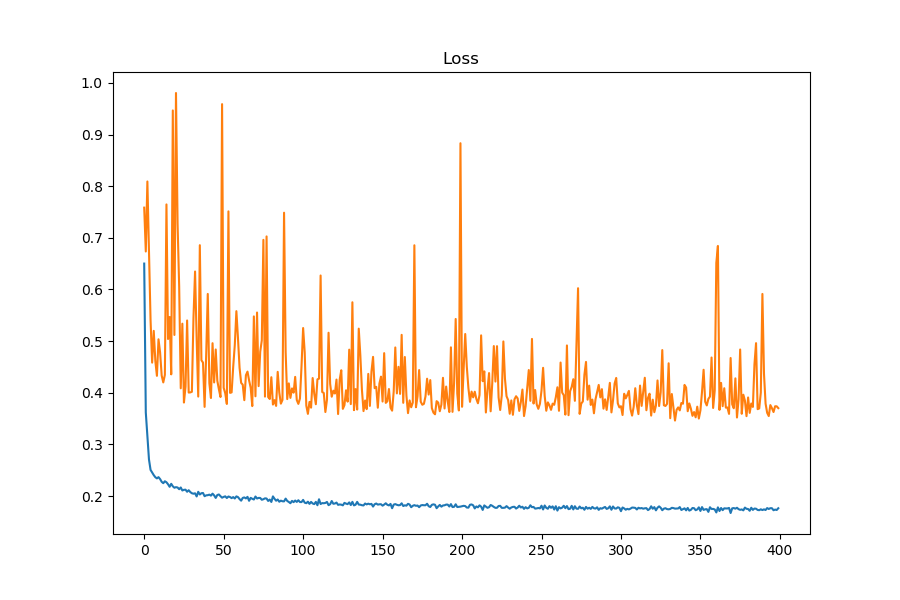

<IPython.core.display.Javascript object>


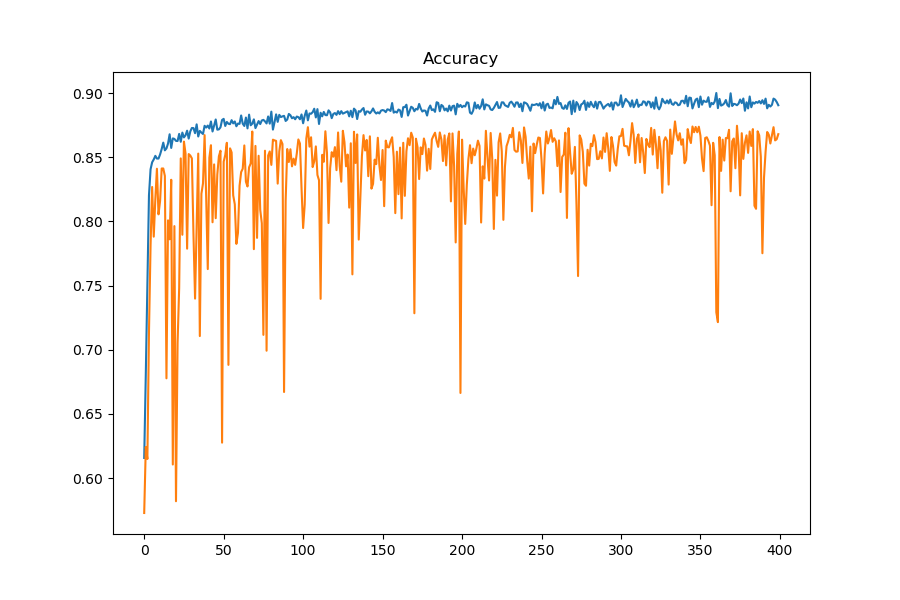

In [15]:
if train:
    plt.figure(figsize=(9, 6))
    plt.title("Loss")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    
    plt.figure(figsize=(9, 6))
    plt.title("Accuracy")
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])

# Results

## Load model

In [16]:
import IPython.display as ipd
from glob import glob

from sklearn.metrics import roc_curve, auc

from microfaune.audio import load_wav
import librosa.display

In [17]:
if not train:
    model.load_weights("model_weights-20190919_220113.h5")

In [18]:
wav_files = {os.path.basename(f)[:-4]: f for f in glob(os.path.join(data_dir, "*/wav/*.wav"))}

In [19]:
dual_model = keras.Model(inputs=model.input, outputs=[model.layers[-1].output, model.layers[-2].output])

## Evaluation on validation dataset

In [20]:
val_uids = val_data_generator.uids
X_val = []
Y_val = []
with h5py.File(dump_file, "r") as f:
    for uid in val_uids:
        X_val.append(f["X"][uid][()])
        Y_val.append(int(f["Y"][uid][()]))

X_val = np.array(X_val)[..., np.newaxis]
Y_val = np.array(Y_val)

In [21]:
scores, local_scores = dual_model.predict(X_val)

In [22]:
Y_hat = scores.squeeze() > 0.5
print(f"Accuracy: {np.mean(Y_hat == Y_val)*100:.2f}")

Accuracy: 86.76


In [23]:
fpr, tpr, sc = roc_curve(Y_val, scores)
print(f"Area under ROC curve: {auc(fpr, tpr):f}")

Area under ROC curve: 0.928722


<IPython.core.display.Javascript object>


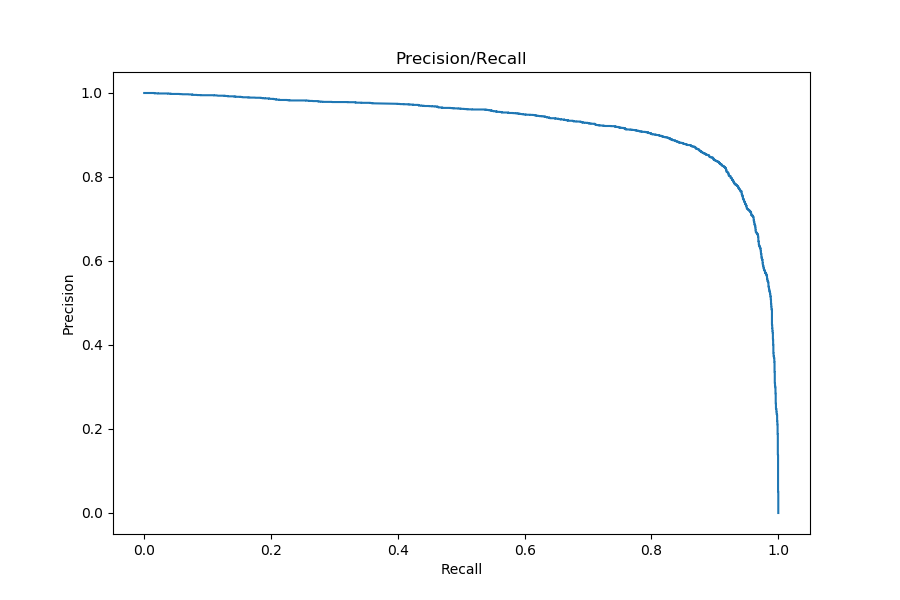

In [24]:
plt.figure(figsize=(9, 6))
plt.plot(1-fpr, tpr)
plt.title("Precision/Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.savefig("imgs/PR_curve.png")

In [29]:
success = np.where(Y_hat == Y_val)[0]
errors = np.where(Y_hat != Y_val)[0]

In [30]:
def check_result(uid, x, y, pred_score, y_hat_time, wav_files=wav_files):
    wav_file = wav_files[uid]
    sr, audio = load_wav(wav_file)
    plt.figure(figsize=(9, 6))
    label_dict = {0: "Negative", 1: "Positive"}
    plt.suptitle(f"UID: '{uid}', {label_dict[y]} example, predicted score: {pred_score[0]:.2f}")

    plt.subplot(3, 1, 1)
    plt.title("Audio wave")
    librosa.display.waveplot(audio, sr)

    plt.subplot(3, 1, 2)
    plt.title("MEL spectrogram")
    librosa.display.specshow(np.rot90(x.squeeze(), -1))

    plt.subplot(3, 1, 3)
    plt.title("Local prediction")
    ax = plt.gca()
    ax.set_xlim(0, x.shape[0])
    ax.set_ylim(-0.05, 1.05)
    plt.plot(y_hat_time)
    return ipd.Audio(wav_file)
    

## success

<IPython.core.display.Javascript object>


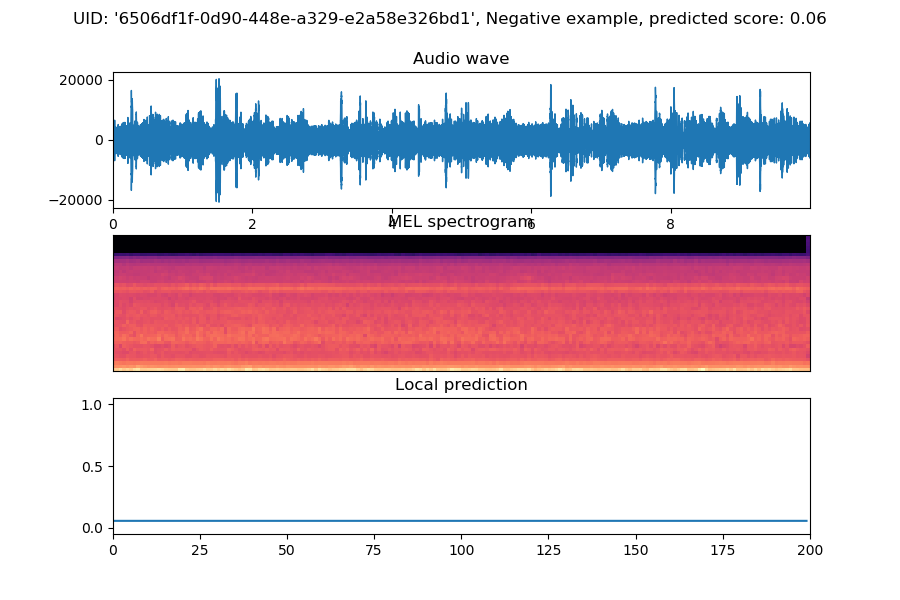

In [32]:
ind = success[10]
check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])

<IPython.core.display.Javascript object>


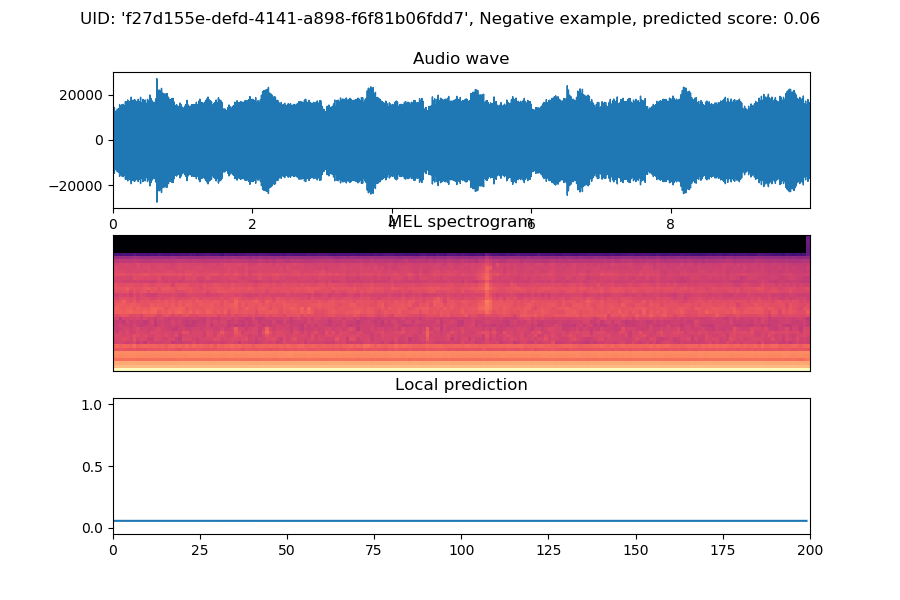

In [33]:
ind = success[26]
reader = check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/positive_success.png")
reader

<IPython.core.display.Javascript object>


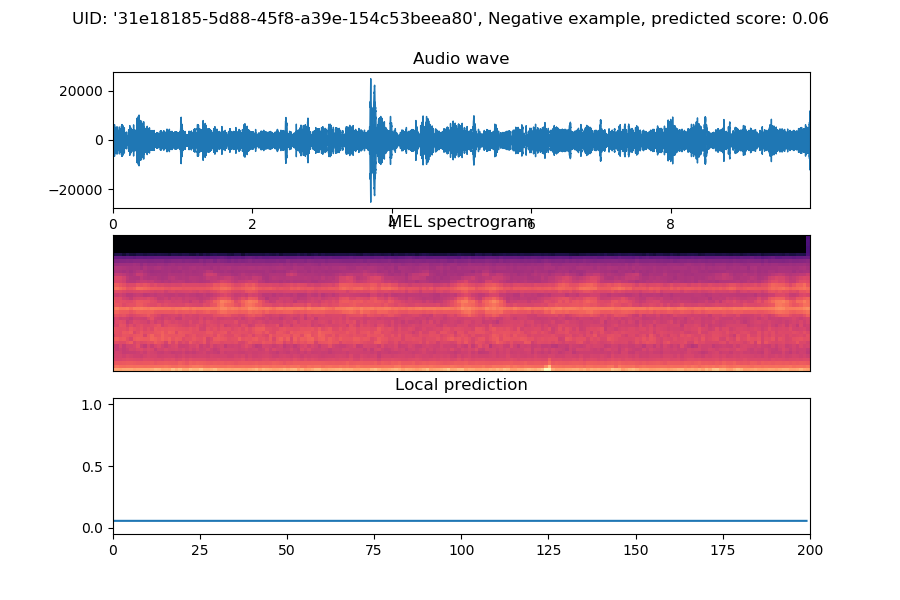

In [34]:
ind = success[15]
check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])

<IPython.core.display.Javascript object>


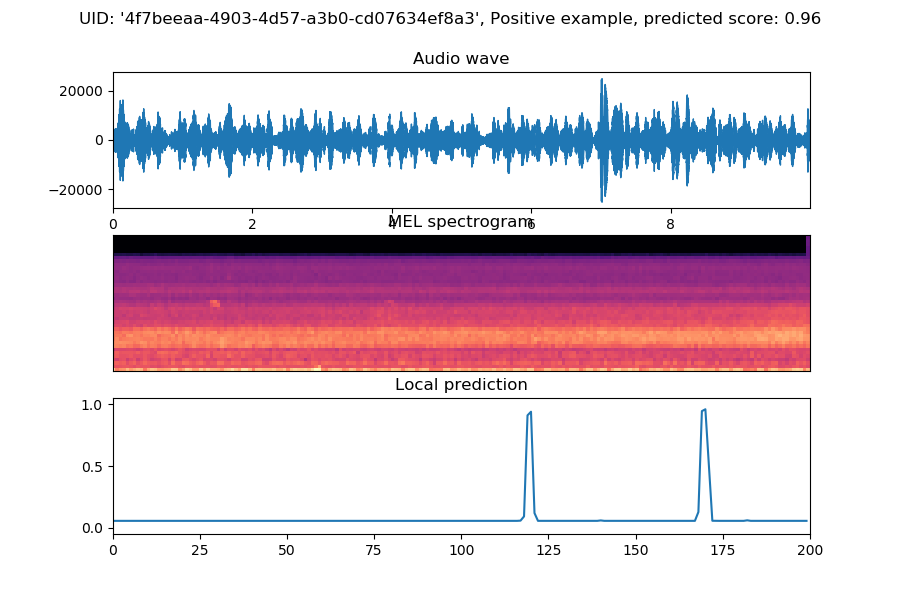

In [35]:
ind = success[1]
check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])

## errors

<IPython.core.display.Javascript object>


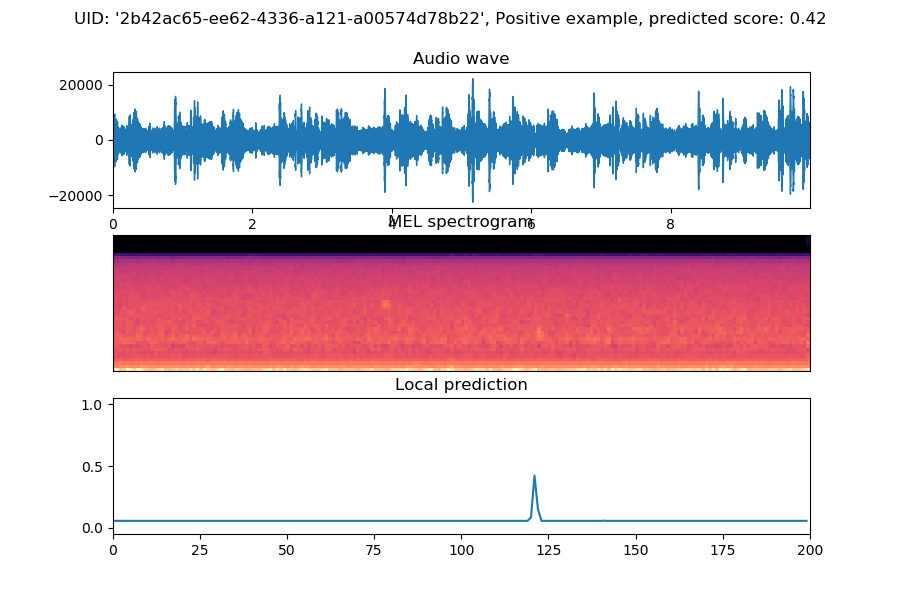

In [36]:
ind = errors[0]
reader = check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/negative_error.png")
reader

<IPython.core.display.Javascript object>


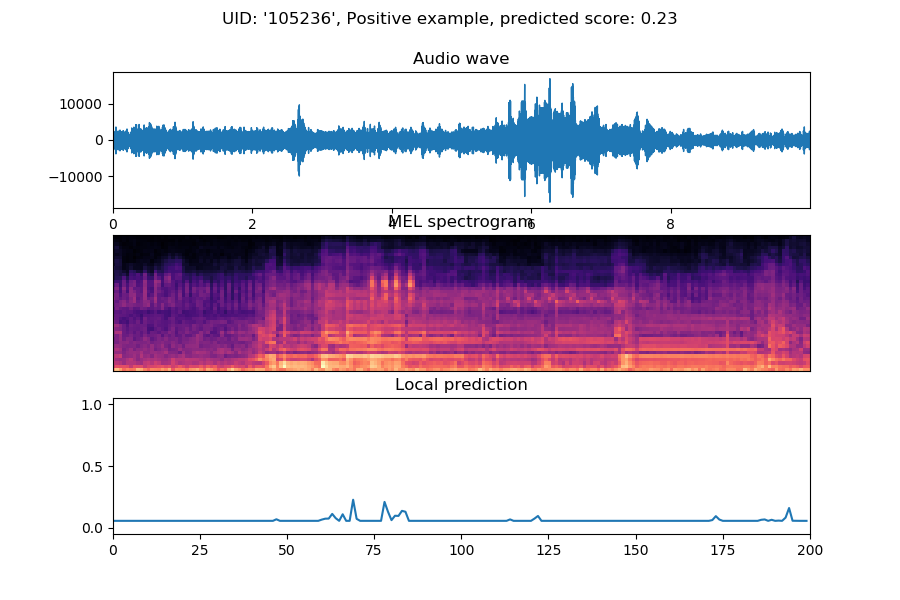

In [37]:
ind = errors[5]
reader = check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/positive_error.png")
reader

## labelling errors?

<IPython.core.display.Javascript object>


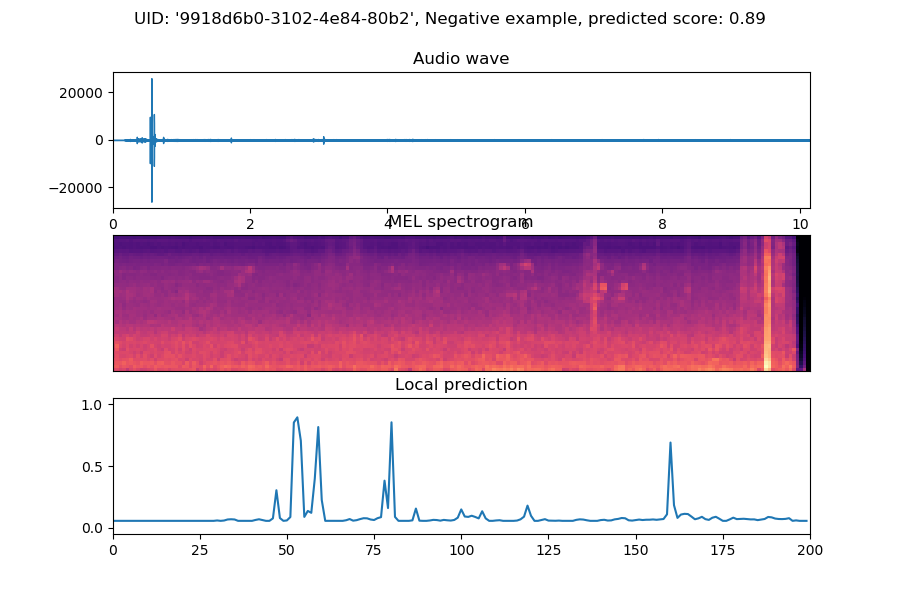

In [39]:
ind = errors[16]
check_result(val_uids[ind], X_val[ind], Y_val[ind], scores[ind], local_scores[ind, :])

## Test on other datasets